### 3. Завантажте датасет CIFAR-10 та використайте HOG для витягування ознак зображень. Застосуйте будь-який простий класифікатор (наприклад SVM) для класифікації зображень та обчисліть метрики точності, такі як accuracy, precision, recall та F1-score.
### 4. Використайте метод SIFT для витягування ознак з зображень та порівняйте його з методом HOG за допомогою метрик точності.

In [1]:
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
# from skimage import exposure
from sklearn import svm
from sklearn import metrics
import numpy as np

In [43]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='latin1')
    return dic

def preprocessing_data(path, filename):    
    data_batch = unpickle(filename)
    data = data_batch['data']
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    labels = data_batch['labels']
    return data, labels

def get_hog_features(data):
    features=[]    
    for img in data:
        fd = hog(img, orientations=8, pixels_per_cell=(8, 8),
                 cells_per_block=(1, 1), channel_axis=-1)
        features.append(fd)
    return features

def get_sift_features(data, labels, n_features):
    sift = cv2.SIFT_create(n_features)
#     sift = cv2.SIFT_create(5, nOctaveLayers = 4, contrastThreshold=0.01, edgeThreshold=10)
    features=[]
    keypoints=[]
    new_labels = []
    for j in range(len(data)):
        gray = cv2.cvtColor(data[j], cv2.COLOR_BGR2GRAY)        
        _, descr = sift.detectAndCompute(data[j], None)
        
        if descr is not None:
            if descr.shape[0] < n_features:
                descr.resize((n_features, 128), refcheck=False)            
                std_descriptor = descr
            elif descr.shape[0] > n_features:
                std_descriptor = descr[:n_features]
            else: 
                std_descriptor = descr

            features.append(std_descriptor.ravel())
            new_labels.append(labels[j])
            
    return features, new_labels

def print_metrics(y_test, y_pred):
    accuracy = np.mean(y_test == y_pred)
    print(f'Accuracy score: {accuracy:.4f}')
    macro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'macro')
    print(f"Macro-Averaged Precision score: {macro_averaged_precision:.4f}")
    macro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'macro')
    print(f"Macro-Averaged Recall score: {macro_averaged_recall:.4f}")
    macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
    print(f"Macro-Averaged F1 score: {macro_averaged_f1:.4f}")

#### Load & prepared data

In [3]:
path = r'C:\Users\Game On Dp\PycharmProjects\PDS\cifar-10-batches-py\\'
b_num = 5 # Number of batches

total_labels=[]
total_hog_features=[]
total_sift_features=[]
total_sift_labels=[]
for i in range(1, b_num+1):
    filename = path + 'data_batch_'+ str(i)
    print(f'Processing data_batch_{i}')
    data, labels = preprocessing_data(path, filename)    
    total_hog_features.extend(get_hog_features(data))
    total_labels.extend(labels)
    sift_features, sift_labels = get_sift_features(data, labels, 5)
    total_sift_features.extend(sift_features)
    total_sift_labels.extend(sift_labels)
  
    
    

Processing data_batch_1
Processing data_batch_2
Processing data_batch_3
Processing data_batch_4
Processing data_batch_5


#### Visualize samples

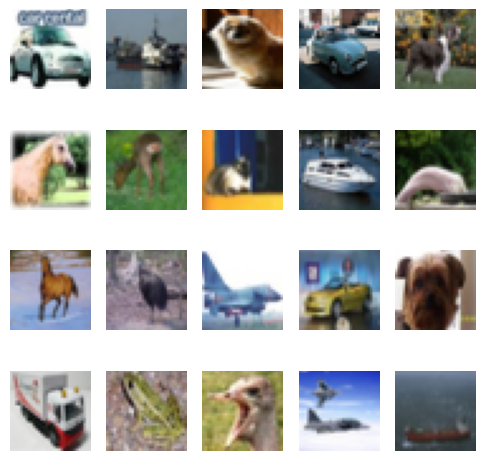

In [4]:
columns = 5
rows = 4
fig = plt.figure(figsize=(6,6))
for i in range(columns*rows):
    plt.subplot(rows, columns, i+1)
    plt.imshow(data[i])    
    plt.axis('off')
plt.show()    

#### Prepare testing data

In [5]:
test_file = path + 'test_batch'
test_data, test_labels = preprocessing_data(path, test_file)
test_features = get_hog_features(test_data)

#### Build classifier model for HOG features

In [6]:
clf_rbf = svm.SVC(kernel='rbf') # rbf Kernel

In [7]:
# %%timeit
clf_rbf.fit(total_hog_features, total_labels)

SVC()

#### Make prediction, metrics for HOG features

In [8]:
pred_labels = clf_rbf.predict(test_features)

In [9]:
print_metrics(test_labels, pred_labels)

Accuracy score: 0.5471
Macro-Averaged Precision score: 0.5448
Macro-Averaged Recall score: 0.5471
Macro-Averaged F1 score: 0.5449


#### Build classifier model for SIFT features

In [10]:
clf2_rbf = svm.SVC(kernel='rbf') # rbf Kernel

In [11]:
clf2_rbf.fit(total_sift_features, total_sift_labels)

SVC()

In [12]:
test_sift_features, test_sift_labels = get_sift_features(test_data, test_labels, 5)

#### Make prediction, metrics for SIFT features

In [13]:
pred_labels = clf2_rbf.predict(test_sift_features)

In [44]:
print_metrics(test_sift_labels, pred_labels)

Accuracy score: 0.2955
Macro-Averaged Precision score: 0.2946
Macro-Averaged Recall score: 0.2956
Macro-Averaged F1 score: 0.2945
